# Source finding

## 1. Initialisation

In [4]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from time import time
from scipy import stats
import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

## 2. Read data

In [6]:
importlib.reload(scripts.read_data)
object_name, data, wcs = scripts.read_data.run(34, (0, 0, 1))

Read dataset 34: "Section (0, 0, 1) in Tobias' noiseless datacube" (175, 190, 190) (0.34 s)


## 3. Sort data

In [7]:
importlib.reload(scripts.sort_data)
argsorted_data, n_valid = scripts.sort_data.run(data.ravel())

Sorted 6317500 finite measurements in ascending order (0.291 s)


## 4. Hierarchical Overdensity Tree (HOT)

In [8]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(data.strides)//data.itemsize, data.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(data, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

HOT: 43881 overdensities found, 6317500 "pixels" (100%), 1 independent regions
     3.75 seconds


In [9]:
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
#max_test_stat = catalog[3]

## 5. Reliability

1 sources (0.00247 s)


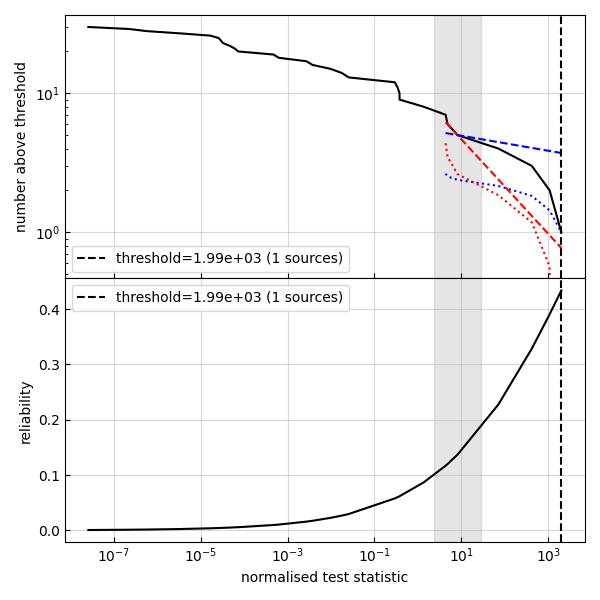

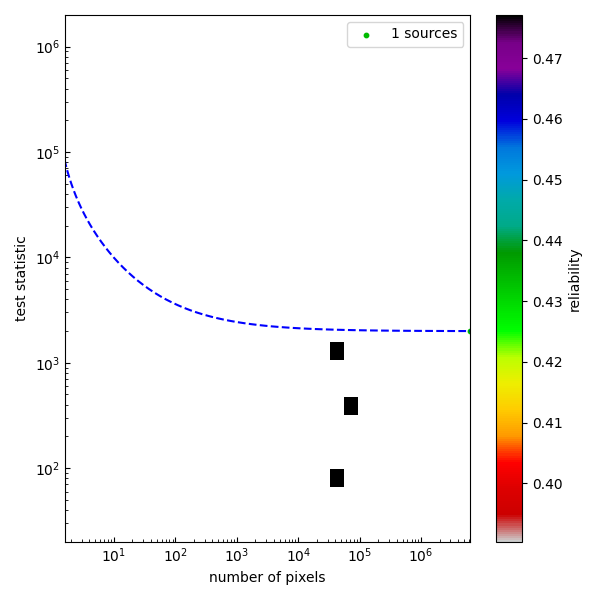

In [10]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(test_stat, area, plots=True)

In [11]:
true_overdensity = reliability > 0
n_sources = np.count_nonzero(true_overdensity)
print(f'{n_sources} potential sources found')

1 potential sources found


## 6. Clean-up

In [12]:
importlib.reload(scripts.cleanup)
label, old_label = scripts.cleanup.run(label, parent, area, true_overdensity, plots=True)

Prune HOT...
 43881 yet to go
 33120 yet to go
 23919 yet to go
 14411 yet to go
 6563 yet to go
 2177 yet to go
 437 yet to go
 39 yet to go
 1 yet to go
... and rename labels
2 objects, 0.00485 seconds


## 7. Compute weights

In [85]:
def old_compute_weight(object_label, label_map, secondary_map):
    weight = np.zeros_like(data)

    #target = np.where(((label_map == object_label) | (secondary_map == object_label)) & (np.isfinite(data)))
    target = np.where((label_map == object_label) & (np.isfinite(data)))
    n_target = target[0].size
    if n_target <= 3:
        print(f'> WARNING: object {object_label} is empty')
        return weight

    weight[target] = data[target]
    background = np.min(data[target])
    secondary = np.where((secondary_map == object_label) & (np.isfinite(data)))
    if secondary[0].size > 0:
        background = min(background, np.min(data[secondary]))
    weight[target] -= background
    norm = np.nansum(weight)
    #print(f'object {object_label}: {n_target} pixels, flux={norm:.3g} ({100*norm/background/n_target:.3g}% of background={background:.3g})')

    weight = np.fft.rfftn(weight)
    weight = np.fft.irfftn(weight*np.absolute(weight)/norm)
    weight[weight < -np.min(weight)] = 0
    weight /= np.nansum(weight)
    weight *= norm+background*n_target

    return weight

In [156]:
def compute_weight(object_label, label_map, secondary_map, verbose=False):

    primary = np.where((label_map == object_label) & (np.isfinite(data)))
    n_primary = primary[0].size
    if n_primary <= 1:
        print(f'> WARNING: object {object_label} has {n_primary} elements')
        return None

    weight = np.zeros_like(data)
    weight[primary] = data[primary]
    
    kernel = np.copy(weight)
    #kernel[primary] -= np.min(kernel[primary])
    #kernel[primary] -= np.sqrt(np.mean(kernel[primary]**2)).clip(min=0)
    #norm = np.sum(kernel)
    #kernel = (kernel/norm)**2
    norm = np.sum(kernel)
    #return kernel/norm
    weight = np.fft.rfftn(weight)
    kernel = np.fft.rfftn(kernel/norm)
    weight = np.fft.irfftn(weight*np.absolute(kernel))
    weight *= np.max(data[primary])/np.max(weight)
    #weight = np.fmin(np.abs(data), weight).clip(min=0)
    weight = 1/(1/np.abs(data) + 1/np.abs(weight))
    #weight -= np.min(weight)
    #print(np.sum(data[primary]), np.sum(weight))
    #weight *= np.nansum(data[primary])/np.nansum(weight[primary])
    
    if verbose:
        print(f'> INFO: object {object_label}, norm={norm/n_primary}')
    return weight
    #return np.where(weight < data, weight, data)

In [157]:
t0 = time()
total_weight = np.zeros_like(data)
#new_label = np.zeros_like(label)
#max_weight = np.zeros_like(data)
primary_label = np.zeros_like(label)
secondary_label = np.zeros_like(label)
max_weight = np.zeros_like(data)
second_weight = np.zeros_like(data)
for lbl in np.unique(label):
    if lbl % 50 == 0:
        print(f'Object {lbl}')
    weight = compute_weight(lbl, label, label)
    if weight is not None:
        total_weight += weight

        #update = np.where(weight > max_weight)
        #new_label[update] = lbl
        #max_weight[update] = weight[update]
        update = np.where(weight >= second_weight)
        secondary_label[update] = lbl
        second_weight[update] = weight[update]

        update = np.where(weight >= max_weight)
        secondary_label[update] = primary_label[update]
        primary_label[update] = lbl
        second_weight[update] = max_weight[update]
        max_weight[update] = weight[update]

print(f"{time()-t0:.3g} seconds")

Object 0
Object 50
Object 100
Object 150
Object 200
Object 250
Object 300
Object 350
Object 400
Object 450
Object 500
Object 550
Object 600
Object 650
Object 700
Object 750
Object 800
Object 850
Object 900
Object 950
Object 1000
Object 1050
Object 1100
Object 1150
Object 1200


/tmp/ipykernel_175343/1680261265.py:24: RuntimeWarning: divide by zero encountered in true_divide
  weight = 1/(1/np.abs(data) + 1/np.abs(weight))


95.2 seconds


In [122]:
t0 = time()
new_total_weight = np.zeros_like(data)
'''
'''
new_primary_label = np.zeros_like(label)
new_secondary_label = np.zeros_like(label)
max_weight = np.zeros_like(data)
second_weight = np.zeros_like(data)
for lbl in np.unique(primary_label):
    if lbl % 50 == 0:
        print(lbl)
    weight = compute_weight(lbl, primary_label, secondary_label)
    if weight is not None:
        new_total_weight += weight

        update = np.where(weight >= second_weight)
        new_secondary_label[update] = lbl
        second_weight[update] = weight[update]

        update = np.where(weight >= max_weight)
        new_secondary_label[update] = new_primary_label[update]
        new_primary_label[update] = lbl
        second_weight[update] = max_weight[update]
        max_weight[update] = weight[update]
'''
primary_label = new_primary_label
secondary_label = new_secondary_label
'''

#iteration += 1
#total_weight = new_total_weight
#primary_label = new_primary_label
#secondary_label = new_secondary_label
#print(f"iteration {iteration}: {time()-t0:.3g} seconds")
updated_background = np.nanmean(data)-np.nanmean(new_total_weight)
#new_total_weight += updated_background
print(f"Background level: {updated_background:.3g} ({100*updated_background/np.nanmean(data):.3g}% of the flux) {time()-t0:.3g} seconds")

0
100
200
300
400
500
600
700
800
900
> WARNING: object 998 has 1 elements
1000
1100
> WARNING: object 1154 has 1 elements
1200
Background level: -0.00613 (-46.3% of the flux) 81.1 seconds


## 8. Explore results

### Definitions

In [15]:
plots = True
data_dimensionality = sorted_strides.size-1
#p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
#colour_scale = colors.SymLogNorm(vmin=p50-3*(p50-p16), linthresh= p50+3*(p50-p16), vmax=p100)
#data_min = data.ravel()[argsorted_data[0]]
#pivot = np.percentile(data[data > 0], 1)
#scale_min = data.ravel()[argsorted_data[int(argsorted_data.size*.01)]]
#pivot = data.ravel()[argsorted_data[int(argsorted_data.size*.5)]]  # median
#scale_max = data.ravel()[argsorted_data[int(argsorted_data.size*.99)]]
#scale_max = data.ravel()[argsorted_data[-1]]
#colour_scale = colors.SymLogNorm(vmin=scale_min, linthresh=2*pivot-scale_min, vmax=scale_max)
p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
colour_scale = colors.SymLogNorm(vmin=p16, linthresh=2*p50-p16, vmax=p100+p16)

colour_scale = colors.LogNorm(vmin=p16, vmax=p100)

In [16]:
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)

### Individual objects

In [153]:
study_object = 68

1.2516211225801308 51.22792957205918 0.001172554702820204


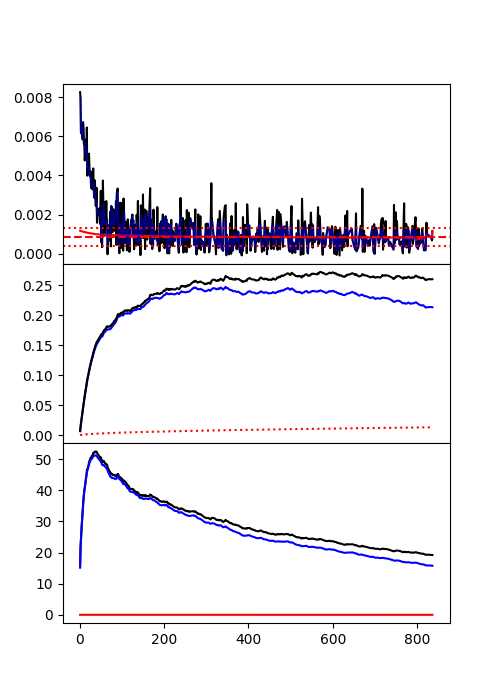

In [154]:
def profile(object_label, label_map):

    primary = np.where((label_map == object_label) & (np.isfinite(data)))
    n_primary = primary[0].size
    if n_primary <= 1:
        print(f'> WARNING: object {object_label} has {n_primary} elements')
        return None

    weight = np.zeros_like(data)
    weight[primary] = data[primary]
    
    kernel = np.copy(weight)
    #kernel[primary] -= np.min(kernel[primary])
    #kernel[primary] -= np.sqrt(np.mean(kernel[primary]**2)).clip(min=0)
    #norm = np.sum(kernel)
    #kernel = (kernel/norm)**2
    norm = np.sum(kernel)

    weight = np.fft.rfftn(weight)
    kernel = np.fft.rfftn(kernel/norm)
    weight = np.fft.irfftn(weight*np.absolute(kernel)).clip(min=0)
    
    sorted_by_weight = np.argsort(weight.flat)[:-n_primary-1:-1]
    weight += np.nan
    weight[primary] = data[primary]
    profile = weight.flat[sorted_by_weight[:n_primary]]
    #profile = data.flat[sorted_by_weight[:n_primary]]
    #delta = np.nancumsum(profile)/np.cumsum(~np.isnan(p))
    return profile


p = profile(study_object, label)
n = 1+np.arange(p.size)
good = np.where(~np.isnan(p))
p = np.interp(n, n[good], p[good])
m = np.cumsum(p)
#n = np.cumsum(~np.isnan(p))
delta_left = m/n
delta_right = np.nancumsum(p[::-1])[::-1]/np.cumsum(~np.isnan(p[::-1]))[::-1]
background = np.nanmedian(delta_right)
sigma = np.sqrt(np.mean((p[p < background]-background)**2))

corrected = np.fmin(p, delta_left)
corrected = np.nanmedian(np.vstack([corrected[:-2], corrected[1:-1], corrected[2:]]), axis=0)
corrected = np.hstack([corrected[0], corrected, corrected[-1]])
signal = np.nancumsum(p) - background*n
corrected_signal = np.nancumsum(corrected) - background*n
signal_to_noise = signal / (sigma*np.sqrt(n))
corrected_signal_to_noise = (corrected_signal / (sigma*np.sqrt(n))).clip(min=0)

fig_name = 'profile'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(5, 7))
axes = fig.subplots(nrows=3, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]
ax.plot(n, p, 'k-')
#ax.plot(n, delta_left, 'b-')
ax.plot(n, delta_right, 'r-')
ax.plot(n, corrected, 'b-', alpha=.5)

#ax.plot(n[p < delta_right], p[p < delta_right], 'r.')
#ax.plot(n[p > delta_left], p[p > delta_left], 'b.')
ax.axhline(background+sigma, c='r', ls=':')
ax.axhline(background, c='r', ls='--')
ax.axhline(background-sigma, c='r', ls=':')
print(np.nansum(p[p > delta_left])/np.nansum(p[p < delta_right]), np.max(corrected_signal_to_noise), np.nanmean(p))

ax = axes[1, 0]
ax.plot(n, corrected_signal, 'b-')
ax.plot(n, signal, 'k-')
ax.plot(n, sigma*np.sqrt(n), 'r:')

ax = axes[2, 0]
ax.plot(n, signal_to_noise, 'k-')
ax.plot(n, corrected_signal_to_noise, 'b-')
ax.plot(n, ((corrected-background)*(1-np.exp(-.5*corrected_signal_to_noise**2))).clip(min=0), 'r-')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


KeyboardInterrupt: 

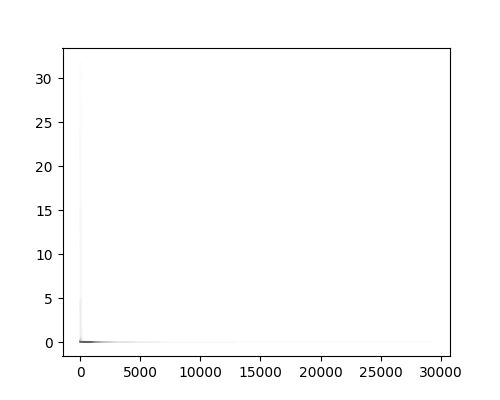

In [96]:
fig_name = 'PSF'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(5, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

def profile(object_label, label_map):

    primary = np.where((label_map == object_label) & (np.isfinite(data)))
    n_primary = primary[0].size
    if n_primary <= 1:
        print(f'> WARNING: object {object_label} has {n_primary} elements')
        return None

    weight = np.zeros_like(data)
    weight[primary] = data[primary]
    
    kernel = np.copy(weight)
    #kernel[primary] -= np.min(kernel[primary])
    #kernel[primary] -= np.sqrt(np.mean(kernel[primary]**2)).clip(min=0)
    #norm = np.sum(kernel)
    #kernel = (kernel/norm)**2
    norm = np.sum(kernel)

    weight = np.fft.rfftn(weight)
    kernel = np.fft.rfftn(kernel/norm)
    weight = np.fft.irfftn(weight*np.absolute(kernel)).clip(min=0)
    
    sorted_by_weight = np.argsort(weight.flat)[:-n_primary-1:-1]
    weight += np.nan
    weight[primary] = data[primary]
    profile = weight.flat[sorted_by_weight[:n_primary]]
    #delta = np.nancumsum(profile)/np.cumsum(~np.isnan(p))
    return profile


for obj in np.unique(label)[1:]:
    print(obj)
    p = profile(obj, label)
    n = 1+np.arange(p.size)
    good = np.where(~np.isnan(p))
    p = np.interp(n, n[good], p[good])
    m = np.cumsum(p)
    #n = np.cumsum(~np.isnan(p))
    delta_left = m/n
    delta_right = np.nancumsum(p[::-1])[::-1]/np.cumsum(~np.isnan(p[::-1]))[::-1]
    background = np.nanmedian(delta_right)
    sigma = np.sqrt(np.mean((p[p < background]-background)**2))

    corrected = np.fmin(p, delta_left)
    corrected = np.nanmedian(np.vstack([corrected[:-2], corrected[1:-1], corrected[2:]]), axis=0)
    corrected = np.hstack([corrected[0], corrected, corrected[-1]])
    corrected_signal = np.nancumsum(corrected) - background*n
    corrected_signal_to_noise = (corrected_signal / (sigma*np.sqrt(n))).clip(min=0)

    ax = axes[0, 0]
    ax.plot(n, ((corrected-background)*(1-np.exp(-.5*corrected_signal_to_noise**2))).clip(min=0), 'k-', alpha=.01)


In [73]:
n.size, p.size, corrected.size

(6274042, 6274042, 6274042)

> INFO: object 68, norm=0.0010012124428908792


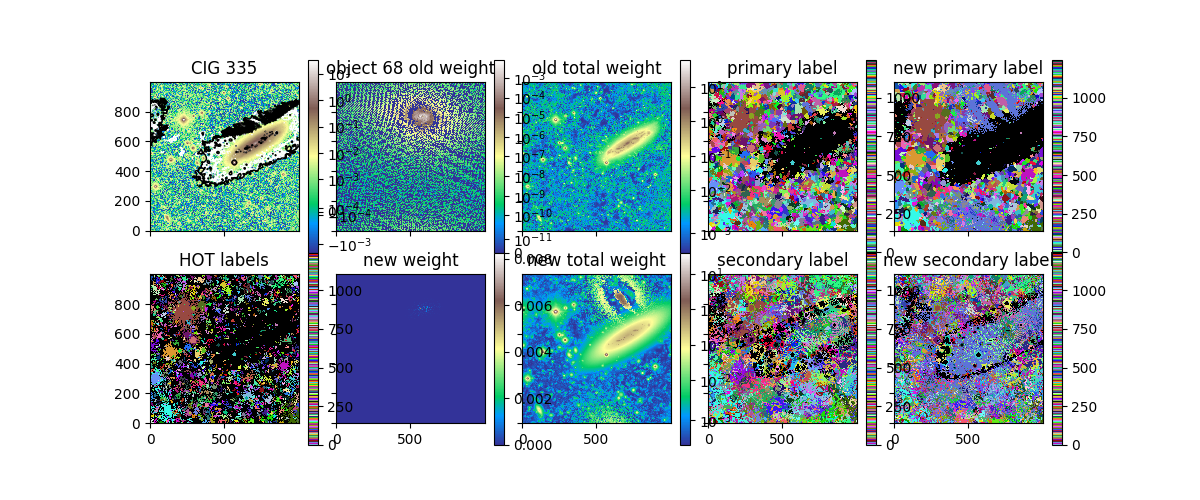

In [155]:
def show_data(data, fig, ax, cmap):
    p0, p1, p50, p99, p100 = np.nanpercentile(data, [0, 1, 50, 99.9, 100])
    rms = np.sqrt(np.nanmean(data**2))
    if p50 > 0:
        colour_scale = colors.SymLogNorm(vmin=p1, linthresh=p50, vmax=p100)
    else:
        colour_scale = colors.Normalize(vmin=p0, vmax=p100)
    im = ax.imshow(
        data,
        interpolation='nearest', origin='lower',
        cmap=cmap,
        norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    
def explore_weight(object_label, data, labels, total_weight, intensity_scale):
    fig_name = 'explore_weight'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 5))
    axes = fig.subplots(nrows=2, ncols=5, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    old_weight = compute_weight(object_label, label, label, verbose=True)
    new_weight = compute_weight(object_label, primary_label, secondary_label)
    if old_weight is None:
        old_weight = np.zeros_like(data)
    if new_weight is None:
        new_weight = np.zeros_like(data)

    ax = axes[0, 0]
    ax.set_title(f'{object_name}')
    show_data(data, fig, ax, 'terrain')
    ax.contour(primary_label, levels=[.5], colors='w', linewidths=.5)
    ax.contour(new_primary_label, levels=[.5], colors='k', linewidths=1)

    ax = axes[0, 1]
    ax.set_title(f'object {object_label} old weight')
    show_data(old_weight, fig, ax, 'terrain')

    ax = axes[0, 2]
    ax.set_title(f'old total weight')
    show_data(total_weight, fig, ax, 'terrain')

    ax = axes[0, 3]
    ax.set_title(f'primary label')
    im = ax.imshow(
        primary_label,
        interpolation='nearest', origin='lower',
        vmin=-.5, vmax=n_sources-.5, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 4]
    ax.set_title(f'new primary label')
    im = ax.imshow(
        new_primary_label,
        interpolation='nearest', origin='lower',
        vmin=-.5, vmax=n_sources-.5, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[1, 0]
    ax.set_title(f'HOT labels')
    im = ax.imshow(
        label,
        interpolation='nearest', origin='lower',
        vmin=-.5, vmax=n_sources-.5, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[1, 1]
    ax.set_title(f'new weight')
    show_data(new_weight, fig, ax, 'terrain')

    ax = axes[1, 2]
    ax.set_title(f'new total weight')
    show_data(new_total_weight, fig, ax, 'terrain')

    ax = axes[1, 3]
    ax.set_title(f'secondary label')
    im = ax.imshow(
        secondary_label,
        interpolation='nearest', origin='lower',
        vmin=-.5, vmax=n_sources-.5, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[1, 4]
    ax.set_title(f'new secondary label')
    im = ax.imshow(
        new_secondary_label,
        interpolation='nearest', origin='lower',
        vmin=-.5, vmax=n_sources-.5, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)


    
explore_weight(study_object, data, label, total_weight, colour_scale)

In [138]:
np.where(label==study_object)

(array([747, 747]), array([222, 223]))

In [112]:
np.unique(primary_label).size, np.unique(new_primary_label).size

(1242, 1147)

> 0 0.008611899450454825 0.46641963173648693 1 6317500 0.7801315437297998
> 1 0.009527764601449837 0.5030219389002341 395 2330 0.214973891524032
> 2 0.009838581158056782 0.5137154057406155 2 2067 0.3581601261186984
> 3 0.009559599008173453 0.5041171835564339 86 1345 0.20451865275105088
> 4 0.008941267411377534 0.4828438366701583 333 1322 0.23800668629563376
> 5 0.009356900176213597 0.49714344553613976 2100 1300 0.20822621699840965
> 6 0.009456092818965308 0.5005561119901234 3220 1237 0.2386013799361602
> 7 0.009686433225728418 0.5084808426692426 3306 915 0.20898298985076844
> 8 0.009674838245241915 0.5080819239607258 640 857 0.21724582875613951
> 9 0.009165936344822365 0.4905734435356456 1817 847 0.22175838775940762
> 10 0.009501669839062282 0.5021241634427579 5812 822 0.20711531882586603
> 11 0.010425394896773264 0.5339043986467441 3 781 0.2308953735206766
> 12 0.009685593502828728 0.5084519524805057 202 776 0.21054827810158622
> 13 0.00939664672122029 0.4985109028096153 4037 775 0.20

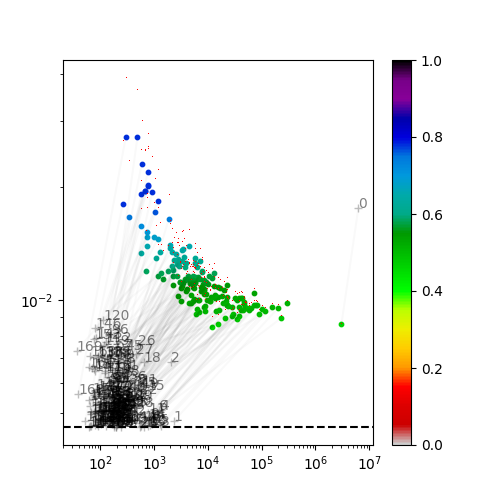

In [61]:
z_Chernoff_max = 1 + np.logspace(-3, 3, 101)
n_Chernoff_max = 1 - 2*np.log(1/test_stat.size)/(z_Chernoff_max-1-np.log(z_Chernoff_max))

fig_name = 'new_reliability'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(5, 5))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]
t0 = test_stat[true_overdensity] / 10**np.interp(area[true_overdensity], n_Chernoff_max[::-1], np.log10(z_Chernoff_max)[::-1])
ax.plot(area[true_overdensity], t0, 'k+', alpha=.25)
ax.axhline(np.min(t0), c='k', ls='--')
sorted_by_t0 = np.argsort(t0)

for lbl in np.unique(label):
    l = old_label[lbl]
    t = test_stat[l] / 10**np.interp(area[l], n_Chernoff_max[::-1], np.log10(z_Chernoff_max)[::-1])
    if t > 0:
        ax.text(area[l], t, f'{lbl}', alpha=.5)

#ax.plot(n_Chernoff_max, z_Chernoff_max, 'b--')

final = []
for lbl in np.unique(primary_label):
    primary = np.where(primary_label == lbl)
    n_primary = primary[0].size
    t = np.nanvar(data[primary])
    ax.plot(n_primary, t, 'r,')
    t /= 10**np.interp(n_primary, n_Chernoff_max[::-1], np.log10(z_Chernoff_max)[::-1])
    if t > t0[sorted_by_t0][0]:
        r = np.interp(t, t0[sorted_by_t0], reliability[true_overdensity][sorted_by_t0])
        print('>', lbl, t, r, old_label[lbl], area[old_label[lbl]], reliability[old_label[lbl]])
        final.append(lbl)
        ax.plot([area[old_label[lbl]], n_primary],
                [test_stat[old_label[lbl]]/10**np.interp(area[old_label[lbl]], n_Chernoff_max[::-1], np.log10(z_Chernoff_max)[::-1]), t],
               'k-', alpha=.025)
        sc = ax.scatter(n_primary, t, marker='o', s=10, c=r, cmap='nipy_spectral_r', vmin=0, vmax=1)
    else:
        ax.plot(n_primary, t, 'kx')
        print(' ', lbl, t)
cb = fig.colorbar(sc, ax=ax)

ax.set_yscale('log')
ax.set_xscale('log')

In [50]:
len(final)

170

In [ ]:
    '''
    ax.set_title(f'old lables')
    im = ax.imshow(
        label,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    ax.set_title(f'max weight')
    im = ax.imshow(
        max_weight,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    ax.set_title(f'new weight')
    im = ax.imshow(
        new_weight,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    ax.set_title(f'updated fraction')
    im = ax.imshow(
        new_weight/new_total_weight,
        interpolation='nearest', origin='lower',
        cmap='rainbow',
        #norm=colors.LogNorm(vmin=1e-3, vmax=1),
        vmin=0, vmax=1,
        )
    ax.set_title(f'fraction')
    im = ax.imshow(
        weight/total_weight,
        interpolation='nearest', origin='lower',
        cmap='rainbow',
        vmin=0, vmax=1,
        )
    im = ax.imshow(
        total_model,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    '''

> DEBUG: [103 125  84]-[113 151 110] / [108 138  97]: [10 26 26] ((175, 190, 190))
> DEBUG: [101 119  78]-[111 145 104]


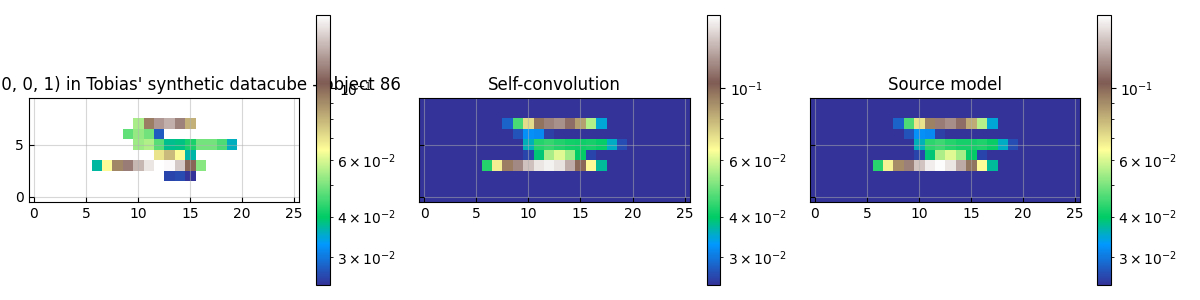

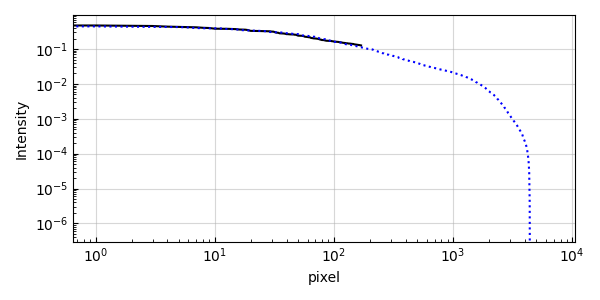

In [51]:
def intensity_map(data):
    return np.nanstd(data, axis=2)

def explore_object_3D(object_label, data, labels, intensity_scale):
    target = np.where(label == object_label)
    target_min = np.nanmin(data[target])
    n_target = target[0].size
    index_min = np.min(target, axis=1).astype(int)
    L = np.minimum(data.shape, 2*(np.max(target, axis=1).astype(int) - index_min))
    print(f'> DEBUG: {index_min}-{index_min+L} / {np.max(target, axis=1).astype(int)}: {L} ({data.shape})')
    index_min = np.clip(index_min-L//4, a_min=0, a_max=data.shape-L)
    print(f'> DEBUG: {index_min}-{index_min+L}')

    intensity = np.zeros(L)
    shifted_target = np.ravel_multi_index(target-index_min[:, np.newaxis], intensity.shape)
    intensity.flat[shifted_target] = data[target]
    decreasing_intensity = np.argsort(intensity.flat[shifted_target])[::-1]

    transform = np.fft.rfftn(intensity)
    convolution = np.fft.irfftn(transform*np.absolute(transform))
    decreasing_model = np.argsort(convolution.flat)[::-1]
    convolution *= np.sum(intensity) / np.sum(convolution.flat[decreasing_model[:n_target]])

    model = convolution.copy()
    #model.flat[decreasing_model[:n_target]] = intensity.flat[shifted_target][decreasing_intensity]
    #model.flat[decreasing_model[:n_target]] = np.maximum(model.flat[decreasing_model[:n_target]], intensity.flat[shifted_target][decreasing_intensity])
    convolution_weight = np.arange(n_target)/n_target
    model.flat[decreasing_model[:n_target]] = (
        convolution_weight * model.flat[decreasing_model[:n_target]] + (1-convolution_weight) * intensity.flat[shifted_target][decreasing_intensity])
    

    fig_name = 'explore_object'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 3))    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        #gridspec_kw={'hspace': 0, 'wspace': 0}
                       )

    ax = axes[0, 0]
    ax.set_title(f'{object_name} - object {object_label}')
    im = ax.imshow(
        intensity_map(intensity),
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 1]
    ax.set_title('Self-convolution')
    im = ax.imshow(
        intensity_map(convolution),
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 2]
    ax.set_title('Source model')
    im = ax.imshow(
        intensity_map(model),
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

    
    fig_name = 'object_intensity_profile'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(6, 3))
    axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.plot(intensity.flat[shifted_target][decreasing_intensity], 'k-')
    ax.plot(convolution.ravel()[decreasing_model], 'b:')
    ax.set_ylabel('Intensity')
    ax.set_yscale('log')
    ax.set_xlabel('pixel')
    ax.set_xscale('log')

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()


if data_dimensionality == 3:
    explore_object_3D(study_object, data, label, colors.LogNorm())

### Segmentation

In [17]:
def show_segmentation(intensity, labels, intensity_scale):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 4))
    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 1]
    ax.set_title(object_name)
    '''
    im = ax.imshow(
        total_weight,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    ax = axes[0, 2]
    '''
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        new_label,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    ax = axes[0, 1]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        #labels == study_object,
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 2]
    ax.set_title(f'Reliability')
    im = ax.imshow(
        reliability[old_label[labels]],
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        )
    cb = fig.colorbar(im, ax=ax)
    '''
    '''

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

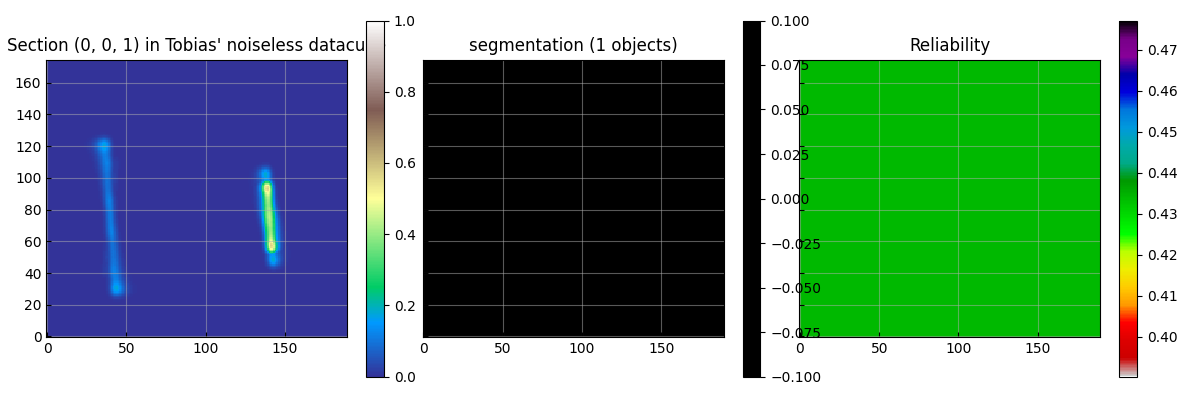

In [18]:
if plots and data_dimensionality == 2:
    show_segmentation(data, label, colour_scale)

elif plots and data_dimensionality == 3:
    #intensity = np.nanmean(data**2, axis=1)
    intensity = np.nanmax(data, axis=1)
    #p16, p50 = np.nanpercentile(intensity, [16, 50])
    #intensity = (intensity-p50)/(p50-p16)
    #intensity_scale = colors.SymLogNorm(vmin=0, linthresh=.1, vmax=10)
    intensity_scale = colors.Normalize(vmin=0, vmax=1)
    show_segmentation(intensity, np.nanmax(label, axis=1), intensity_scale)


/tmp/ipykernel_7686/665751000.py:42: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=0)/np.sqrt(np.nanmean(data**2, axis=0)),


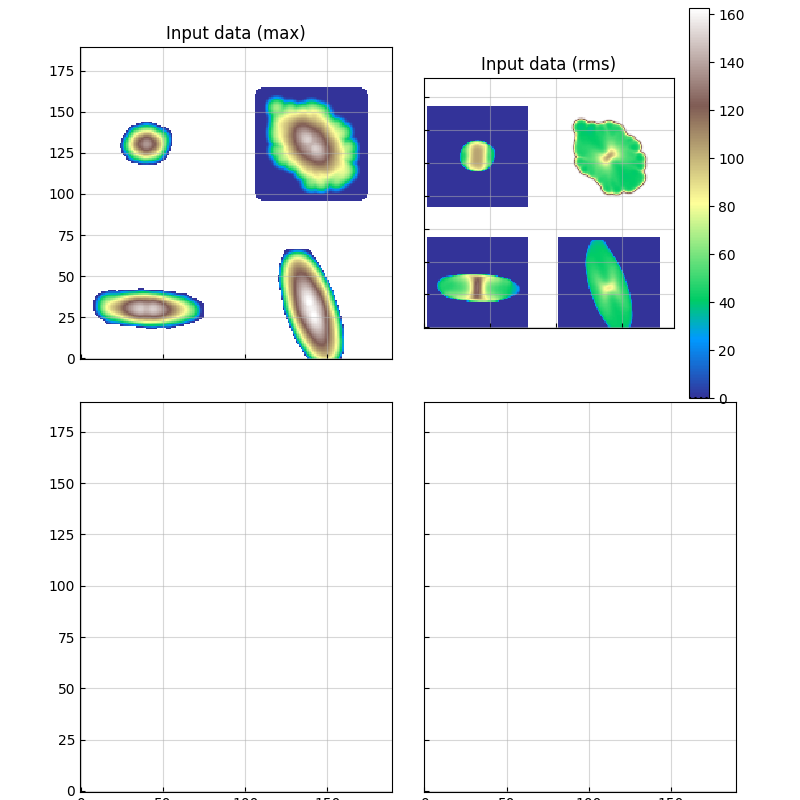

In [35]:
'''
'''
if plots and data_dimensionality == 3:

    mode = 0
    
    #boundary = np.zeros_like(max_map)
    #boundary[:, :-1][max_map[:, :-1] != max_map[:, 1:]] = 1
    #boundary[:-1, :][max_map[:-1, :] != max_map[1:, :]] = 1
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(8, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'bottom': .01, 'left': .1, 'top': .99, 'right': .92,
                                   'hspace': .01, 'wspace': .1},
                      #subplot_kw={'projection': wcs},
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    #fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    #ax[0, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 1].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[0, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 1].contour(max_map, levels=np.arange(n_sources)+.5, colors='w', linewidths=0.1)
    #cb = fig.colorbar(im, ax=ax[0, 0])
    #cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        #(np.sqrt(np.nanmean((data-mode)**2, axis=0)) + np.nanmax(data, axis=0))/2,
        np.nansum(data, axis=0)/np.sqrt(np.nanmean(data**2, axis=0)),
        vmin=0,
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    #ax[0, 1].contour(max_map, levels=[0.5])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    '''
    ax[1, 0].set_title(f'Final selection map (max)\n({n_sources} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    #ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        reliability[old_label[max_map]],
        #np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        #vmin=n_reliable/(n_sources+1), vmax=reliability_threshold,
        #cmap='rainbow_r',
        #vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])
    '''


In [31]:
np.max(data[:, 130, 40])

0.051285446

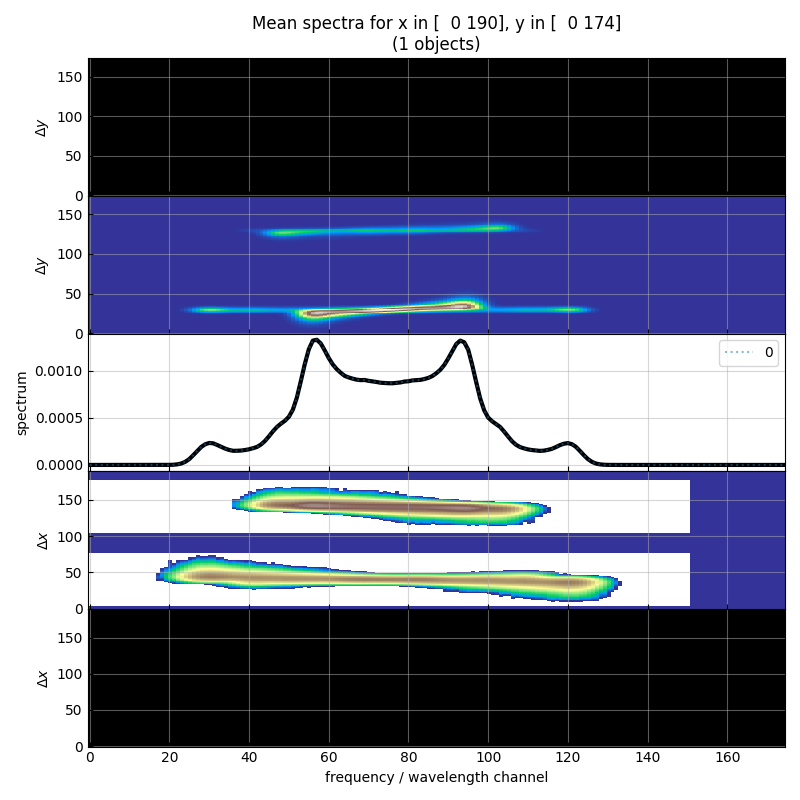

In [32]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('segmentation').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('segmentation').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-mode)
    section_lables = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.max(section_labels, axis=2).T
    horizontal_slit = np.max(section_labels, axis=1).T

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                        )
    #ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    '''
    '''
    for lbl in unique_section_labels[:10]:  # Dirty fix
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
        #(np.nanmax(section, axis=1) + np.sqrt(np.nanmean(section**2, axis=1))).T/2,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #vmin=0,
                         norm=colour_scale,
                        )
    #ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [ ]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


In [ ]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('output/HOT_mask.fits', overwrite=True)
'''
'''
